# Paper ST Sloping - 32 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_32beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,...,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807,-0.008983,NSR
1,e0106,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,...,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060,-0.004790,NSR
2,e0106,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,...,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271,-0.005162,NSR
3,e0106,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,...,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778,-0.000208,NSR
4,e0106,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,...,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157,-0.002940,NSR


In [5]:
data['label'].value_counts()

NSR    13090
ST-     2753
ST+     1229
Name: label, dtype: int64

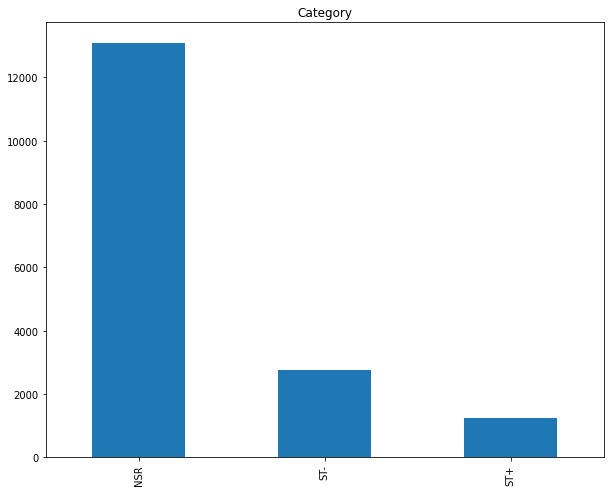

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.237685,0.106778,0.074513,0.049017,0.164754,-0.043134,0.066522,-0.005085,0.007374,...,-0.101746,-0.045780,-0.057627,-0.042941,-0.032342,-0.074357,-0.049488,-0.067248,-0.103371,-0.094220
dw_2,0.237685,1.000000,0.838142,0.502265,0.189472,0.396750,-0.511218,-0.362148,0.007304,0.027974,...,-0.110800,0.180227,0.237271,0.173162,0.054253,0.037079,0.134331,0.012952,-0.116243,-0.070422
dw_3,0.106778,0.838142,1.000000,0.702042,0.287089,0.241283,-0.555562,-0.499643,0.012774,0.016280,...,-0.199872,0.154880,0.275167,0.120954,-0.052022,0.066460,0.043879,-0.017784,-0.133008,-0.045069
dw_4,0.074513,0.502265,0.702042,1.000000,0.873295,-0.014716,-0.278260,-0.278962,0.008457,0.006416,...,-0.152384,0.071768,0.115122,0.067878,-0.039769,0.051749,0.026810,-0.031360,-0.111832,-0.044385
dw_5,0.049017,0.189472,0.287089,0.873295,1.000000,-0.124955,-0.026226,-0.049222,0.001954,0.000388,...,-0.063773,0.011881,-0.006932,0.044290,0.004779,0.016077,0.019832,-0.039655,-0.062702,-0.031614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.074357,0.037079,0.066460,0.051749,0.016077,-0.150115,0.112145,0.135231,-0.002228,0.004135,...,-0.135005,-0.212171,-0.056621,0.041745,0.071561,1.000000,0.024910,0.010580,-0.361983,-0.228896
cfr_13,-0.049488,0.134331,0.043879,0.026810,0.019832,0.073383,-0.006052,0.015178,0.006819,-0.001301,...,0.163738,0.044522,-0.209958,-0.266707,0.009957,0.024910,1.000000,0.238508,0.156749,-0.141656
cfr_14,-0.067248,0.012952,-0.017784,-0.031360,-0.039655,-0.001977,0.028472,0.029755,0.005549,-0.006743,...,0.121685,0.230485,0.039279,-0.173963,-0.282881,0.010580,0.238508,1.000000,0.221302,-0.128261
cfr_15,-0.103371,-0.116243,-0.133008,-0.111832,-0.062702,0.047377,0.081087,0.044183,0.001850,-0.014418,...,0.293341,0.157001,-0.089191,-0.138736,-0.062263,-0.361983,0.156749,0.221302,1.000000,0.344573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_239', 'fft_189', 'fft_236', 'fft_211', 'fft_216', 'fft_159', 'fft_225', 'fft_138', 'fft_204', 'fft_146', 'fft_178', 'fft_240', 'fft_142', 'fft_170', 'fft_163', 'mfw_14', 'fft_192', 'mfw_10', 'fft_156', 'fft_212', 'fft_130', 'fft_237', 'fft_137', 'fft_209', 'mfw_15', 'mfw_11', 'fft_175', 'fft_162', 'fft_186', 'fft_231', 'fft_200', 'fft_188', 'fft_215', 'fft_224', 'fft_143', 'mfw_16', 'fft_243', 'fft_169', 'mfw_13', 'fft_139', 'fft_213', 'fft_235', 'fft_245', 'fft_238', 'fft_187', 'fft_183', 'fft_233', 'fft_185', 'fft_131', 'fft_207', 'fft_167', 'fft_144', 'fft_223', 'fft_202', 'fft_190', 'fft_166', 'fft_249', 'fft_134', 'fft_246', 'fft_160', 'fft_234', 'fft_168', 'fft_174', 'fft_247', 'fft_176', 'fft_220', 'fft_133', 'fft_232', 'fft_222', 'fft_256', 'fft_155', 'fft_171', 'fft_219', 'fft_208', 'fft_191', 'fft_248', 'fft_255', 'fft_165', 'fft_193', 'fft_153', 'fft_205', 'fft_154', 'mfw_6', 'mfw_8', 'fft_157', 'fft_230', 'fft_141', 'fft_254', 'fft_135', 'mfw_7', 'fft_218', 'mfw_9', '

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_19
fft_20
fft_21
fft_22
fft_24
fft_25
fft_26
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 74


### Visualization best features

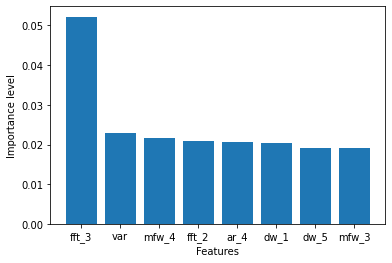

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,-1.009483,...,0.017932,0.038860,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807
1,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,2.486222,...,0.014723,0.042961,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060
2,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,-2.150671,...,0.006243,0.051369,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271
3,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,-4.289119,...,0.014157,0.055342,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778
4,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,-1.067047,...,0.034652,0.022510,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 7.071811676025391 s
Tot: Accuracy 0.927086383601757 Precision 0.927425444765873 Recall 0.927086383601757 Specificity 0.8795640464491787 F1 0.927133537450823
NSR: Accuracy 0.9279648609077599 Precision 0.9552752293577982 Recall 0.9509132420091324 Specificity 0.8513341804320204 F1 0.9530892448512586
ST+: Accuracy 0.9827232796486091 Precision 0.8461538461538461 Recall 0.9205020920502092 Specificity 0.9874055415617129 F1 0.8817635270541082
ST-: Accuracy 0.9827232796486091 precision 0.8293135435992579 Recall 0.8156934306569343 Specificity 0.9679107080572027 F1 0.8224471021159154
#---------------------#
#---------------------#
2 of 1000 - 6.97174072265625 s
Tot: Accuracy 0.9279648609077599 Precision 0.9307457746057329 Recall 0.9279648609077599 Specificity 0.9042751743638997 F1 0.9289153719630836
NSR: Accuracy 0.9288433382137629 Precision 0.9653831194087904 Recall 0.9415781487101669 Specificity 0.8857509627727856 F1 0.9533320530055696
ST+: Accuracy 0.9862371

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.927086,0.927425,0.927086,0.879564,0.927134,0.927965,0.955275,0.950913,0.851334,0.953089,0.982723,0.846154,0.920502,0.987406,0.881764,0.982723,0.829314,0.815693,0.967911,0.822447
1,0.927965,0.930746,0.927965,0.904275,0.928915,0.928843,0.965383,0.941578,0.885751,0.953332,0.986237,0.859375,0.952381,0.988693,0.903491,0.986237,0.794218,0.852190,0.957796,0.822183
2,0.922694,0.923441,0.922694,0.874352,0.922875,0.922987,0.953693,0.946090,0.845070,0.949876,0.979502,0.828671,0.918605,0.984479,0.871324,0.979502,0.817829,0.806883,0.967497,0.812320
3,0.927379,0.928760,0.927379,0.890586,0.927762,0.928258,0.957801,0.947893,0.864596,0.952821,0.976574,0.800000,0.913386,0.981651,0.852941,0.976574,0.850554,0.836661,0.971718,0.843550
4,0.928551,0.929597,0.928551,0.892705,0.928888,0.929429,0.958931,0.948276,0.868323,0.953573,0.983309,0.836000,0.928889,0.987147,0.880000,0.983309,0.833904,0.839655,0.965785,0.836770
5,0.933821,0.933565,0.933821,0.889234,0.933587,0.934114,0.956069,0.957176,0.861482,0.956622,0.987701,0.887597,0.946281,0.990860,0.916000,0.987701,0.852313,0.824441,0.970713,0.838145
6,0.924744,0.925379,0.924744,0.882888,0.924871,0.925622,0.954334,0.947733,0.854859,0.951022,0.981552,0.833333,0.925926,0.985813,0.877193,0.981552,0.832442,0.819298,0.966960,0.825818
7,0.926501,0.927023,0.926501,0.878185,0.926444,0.926501,0.954023,0.950019,0.848866,0.952017,0.982138,0.825926,0.940928,0.985211,0.879684,0.982138,0.842991,0.809695,0.970609,0.826007
8,0.922987,0.923145,0.922987,0.872778,0.922844,0.923865,0.950404,0.949673,0.841133,0.950038,0.980088,0.827206,0.914634,0.985169,0.868726,0.980088,0.839483,0.803887,0.969463,0.821300
9,0.920351,0.922281,0.920351,0.889297,0.920977,0.921523,0.956913,0.939254,0.864865,0.948002,0.981552,0.826087,0.938272,0.984868,0.878613,0.981552,0.805461,0.826620,0.959916,0.815903


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_32beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9260887262079065
Precision 0.9267391692495791
Recall 0.9260887262079065
Specificity 0.8816138411561137
F1 0.9262092472350106
######## NSR ########
Accuracy 0.9268149341142021
Precision 0.9551195002635224
Recall 0.9491271411412444
Specificity 0.8535974336616269
F1 0.9521035459422186
######## ST+ ########
Accuracy 0.9814787701317714
Precision 0.8376477487570939
Recall 0.9212205760343419
Specificity 0.9861565779905176
F1 0.877226926180518
######## ST- ########
Accuracy 0.9814787701317714
Precision 0.83121737184876
Recall 0.8190314047848871
Specificity 0.9679485557118757
F1 0.8249233778420798
